In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import glob
import warnings

## How did student engagement with various types of educational technology change over the course of 2020, and how did engagement levels differ across different types of digital learning tools during that year?

In [2]:
# Read the data file and take a look at the data
df_products = pd.read_csv("products_info.csv") #products_info.csv

### Product information data

The product file `products_info.csv` includes information about the characteristics of the top 372 products with most users in 2020. The categories listed in this file are part of LearnPlatform's product taxonomy. Data were labeled by our team. Some products may not have labels due to being duplicate, lack of accurate url or other reasons.

| Name | Description |
| :--- | :----------- |
| LP ID| The unique identifier of the product |
| URL | Web Link to the specific product |
| Product Name | Name of the specific product |
| Provider/Company Name | Name of the product provider |
| Sector(s) | Sector of education where the product is used |
| Primary Essential Function | The basic function of the product. There are two layers of labels here. Products are first labeled as one of these three categories: LC = Learning & Curriculum, CM = Classroom Management, and SDO = School & District Operations. Each of these categories have multiple sub-categories with which the products were labeled |

In [3]:
df_products = df_products.drop_duplicates() # drop duplicates if any
print(df_products.columns)
print(df_products.info())
df_products = df_products.dropna()#drop NaN values
df_products.head()

Index(['LP ID', 'URL', 'Product Name', 'Provider/Company Name', 'Sector(s)',
       'Primary Essential Function'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 372 entries, 0 to 371
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   LP ID                       372 non-null    int64 
 1   URL                         372 non-null    object
 2   Product Name                372 non-null    object
 3   Provider/Company Name       371 non-null    object
 4   Sector(s)                   352 non-null    object
 5   Primary Essential Function  352 non-null    object
dtypes: int64(1), object(5)
memory usage: 20.3+ KB
None


,LP ID,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms
1,66933,https://abcmouse.com,ABCmouse.com,"Age of Learning, Inc",PreK-12,LC - Digital Learning Platforms
2,50479,https://www.abcya.com,ABCya!,"ABCya.com, LLC",PreK-12,"LC - Sites, Resources & Reference - Games & Si..."
3,92993,http://www.aleks.com/,ALEKS,McGraw-Hill PreK-12,PreK-12; Higher Ed,LC - Digital Learning Platforms
4,73104,https://www.achieve3000.com/,Achieve3000,Achieve3000,PreK-12,LC - Digital Learning Platforms



### Engagement data
The engagement data are aggregated at school district level, and each file in the folder `engagement_data` represents data from one school district. The 4-digit file name represents `district_id` which can be used to link to district information in `district_info.csv`. The `lp_id` can be used to link to product information in `product_info.csv`.

| Name | Description |
| :--- | :----------- |
| time | date in "YYYY-MM-DD" |
| lp_id | The unique identifier of the product |
| pct_access | Percentage of students in the district have at least one page-load event of a given product and on a given day |
| engagement_index | Total page-load events per one thousand students of a given product and on a given day |

In [4]:
#load all engagement data csv
engagement_data = glob.glob("engagement_data/*.csv")
list_df = []
for file in engagement_data:
    df = pd.read_csv(file)
    list_df.append(df)
    
engagement_df = pd.concat(list_df, ignore_index = True)
engagement_df = engagement_df.dropna()#drop NaN values

#Combining Data
df_product_engagement = pd.merge(df_products, engagement_df, left_on = "LP ID", right_on = "lp_id")
df_product_engagement.drop("lp_id",axis = 1, inplace = True)
print(df_product_engagement.columns)
print(df_product_engagement.info())
df_product_engagement.head()

Index(['LP ID', 'URL', 'Product Name', 'Provider/Company Name', 'Sector(s)',
       'Primary Essential Function', 'time', 'pct_access', 'engagement_index'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9026203 entries, 0 to 9026202
Data columns (total 9 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   LP ID                       int64  
 1   URL                         object 
 2   Product Name                object 
 3   Provider/Company Name       object 
 4   Sector(s)                   object 
 5   Primary Essential Function  object 
 6   time                        object 
 7   pct_access                  float64
 8   engagement_index            float64
dtypes: float64(2), int64(1), object(6)
memory usage: 688.6+ MB
None


,LP ID,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function,time,pct_access,engagement_index
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,2020-01-06,0.03,2.09
1,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,2020-01-10,0.03,0.90
2,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,2020-01-16,0.15,3.28
3,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,2020-03-15,0.03,2.96
4,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,2020-03-18,0.03,0.59


## How did engagement levels vary across different types of digital learning tools during COVID-19, and what factors contributed to these differences?

In [5]:
#split df_product_engagement into primary essential functions

#use a chi-square test to test for the association between engagement 
#levels and different types of digital learning tools. 
#This test can be used to determine if there is a statistically significant 
#relationship between engagement levels and the type of digital learning tool being used.

#Hypothesis testing can also be used to compare engagement levels during beginning of 2020 with 
#engagement levels in end of 2020 to determine if there are any significant differences. 
#This can be done using a t-test.

#Primary Essential Function	The basic function of the product. There are two layers of labels here. 
#Products are first labeled as one of these three categories: 
#LC = Learning & Curriculum, CM = Classroom Management, and SDO = School & District Operations. 
#Each of these categories have multiple sub-categories with which the products were labeled

Number of products from Provider/Company:
 Provider/Company Name
The Wikimedia Foundation                                    2
Adobe Inc.                                                  2
LinkedIn                                                    2
ZOOM VIDEO COMMUNICATIONS, INC.                             2
 Tes Global Ltd                                             2
Snap Inc.                                                   2
Lexia Learning                                              2
Renaissance Learning                                        2
GitHub                                                      2
Instructure, Inc.                                           2
Dictionary.com                                              2
Discovery Education                                         2
Teaching.com                                                2
BrainPOP LLC                                                2
 Autodesk, Inc                                              3
Curri

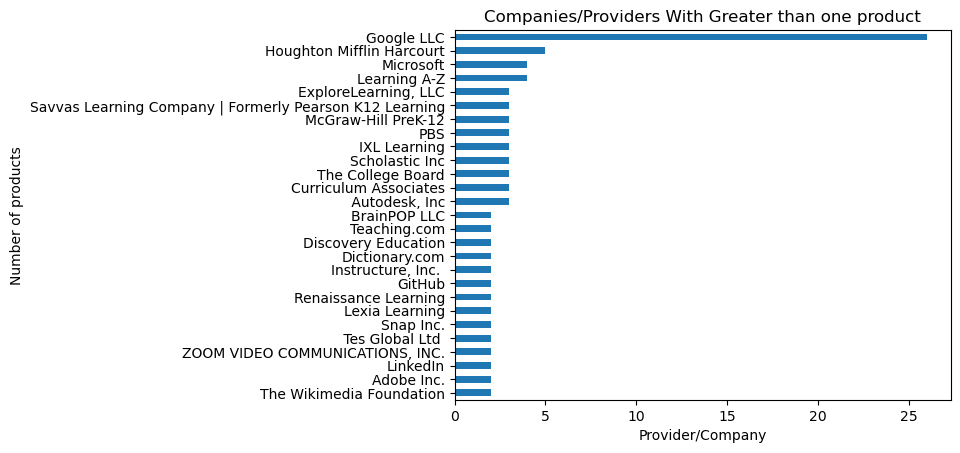

In [6]:
#company/provider vs number of unique products bar chart
num_products_per_company = df_product_engagement.groupby("Provider/Company Name")["Product Name"].nunique().sort_values(ascending = True)
num_products_per_company_filtered = num_products_per_company[num_products_per_company > 1]#Many providers filtered to see providers that have greater than 2 products
num_products_per_company_filtered.plot(kind="barh")
print("Number of products from Provider/Company:\n", num_products_per_company_filtered)
plt.title("Companies/Providers With Greater than one product")
plt.xlabel("Provider/Company")
plt.ylabel("Number of products")
plt.show()

Top 5 Company/Provider for digital learning tools:
- Google LLC - Number of products: 26
- Houghton Mifflin Harcourt - Number of products:  5
- Learning A-Z - Number of products:  4
- Microsoft - Number of products:  3
- ExploreLearning, LLC - Number of products: 3

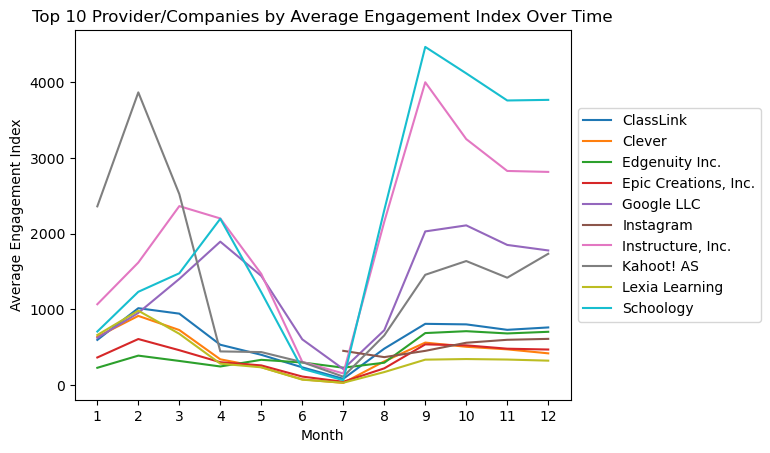

In [7]:
#Checking to see which provider is often used 
#Engagement Index = Total page-load events per one thousand students of a given product and on a given day
df_product_engagement["time"] = pd.to_datetime(df_product_engagement["time"])
df_product_engagement["month"] = df_product_engagement["time"].dt.month
company_engagement_index_by_month_df = df_product_engagement.groupby(["Provider/Company Name", "month"])["engagement_index"].mean().sort_values(ascending=False)
company_engagement_index_by_month_df = company_engagement_index_by_month_df.reset_index()
top_10 = company_engagement_index_by_month_df.groupby("Provider/Company Name")["engagement_index"].mean().sort_values(ascending=False).head(10)
top_10_df = company_engagement_index_by_month_df[company_engagement_index_by_month_df["Provider/Company Name"].isin(top_10.index)]
top_10_df.pivot(index = "month", columns = "Provider/Company Name", values = "engagement_index").plot(kind = "line")
plt.title("Top 10 Provider/Companies by Average Engagement Index Over Time")
plt.xlabel("Month")
plt.ylabel("Average Engagement Index")
plt.legend(loc = "center left", bbox_to_anchor=(1.0, 0.5))
plt.xticks(np.arange(1, 13, 1))
plt.show()

Top 10 Company/Provider based on average Engagement Index:
 Provider/Company Name
Schoology                          2336.762399
Instructure, Inc.                  2159.782146
Kahoot! AS                         1503.386972
Google LLC                         1401.154512
ClassLink                           666.844419
Seesaw Learning Inc                 628.701885
Instagram                           521.411663
Clever                              450.831904
Edgenuity Inc.                      449.549463
ZOOM VIDEO COMMUNICATIONS, INC.     377.257367
Name: engagement_index, dtype: float64


Text(0, 0.5, 'Average Engagement Index')

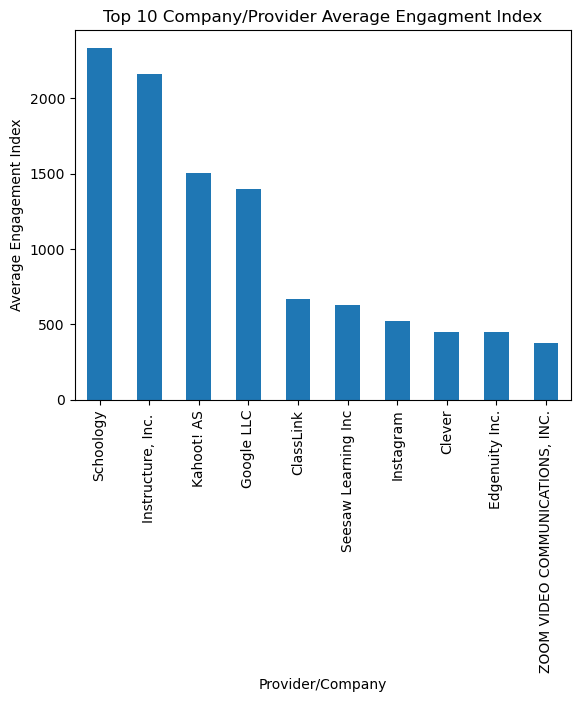

In [8]:
average_comp = df_product_engagement.groupby(["Provider/Company Name"])["engagement_index"].mean().sort_values(ascending = False).head(10)
print("Top 10 Company/Provider based on average Engagement Index:\n",average_comp)
average_comp.plot(kind="bar")
plt.title("Top 10 Company/Provider Average Engagment Index")
plt.xlabel("Provider/Company")
plt.ylabel("Average Engagement Index")

- kahoot!AS has the highest engagement index between month 1 and month 2
- Instructure, Inc has the highest engagement index between the month 3 and month 4
- Schoology has the highest engagement index between month 7 and month 12
- June(month 6) to July(Month 7)all provider/company Engagement index declines which makes sense this is when the school year is coming to an end. 
- August(month 8) to September(month 9) all top 10 provider/companies average engagement index show an upward trend due to the new school year beggining. 

Top 10 company/provider:
- Schoology-                          Average Engagement index: 2337
- Instructure, Inc.-                  Average Engagement index: 2160
- Kahoot! AS-                         Average Engagement index: 1503
- Google LLC-                         Average Engagement index: 1401
- ClassLink-                          Average Engagement index: 667
- Seesaw Learning Inc-                Average Engagement index: 629
- Instagram-                          Average Engagement index: 521
- Clever-                             Average Engagement index: 451
- Edgenuity Inc.-                     Average Engagement index: 450
- ZOOM VIDEO COMMUNICATIONS, INC.-    Average Engagement index: 377

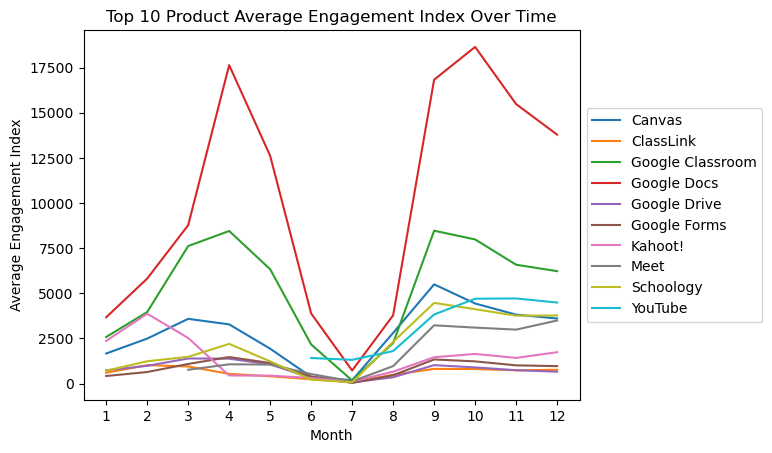

In [9]:
company_engagement_index_by_month_df = df_product_engagement.groupby(["Product Name", "month"])["engagement_index"].mean().sort_values(ascending=False)
company_engagement_index_by_month_df = company_engagement_index_by_month_df.reset_index()
top_10 = company_engagement_index_by_month_df.groupby("Product Name")["engagement_index"].mean().sort_values(ascending=False).head(10)
top_10_df = company_engagement_index_by_month_df[company_engagement_index_by_month_df["Product Name"].isin(top_10.index)]
top_10_df.pivot(index = "month", columns = "Product Name", values = "engagement_index").plot(kind = "line")
plt.title("Top 10 Product Average Engagement Index Over Time")
plt.xlabel("Month")
plt.ylabel("Average Engagement Index")
plt.legend(loc = "center left", bbox_to_anchor=(1.0, 0.5))
plt.xticks(np.arange(1, 13, 1))
plt.show()

- Google Docs is has the highest engagement index over time 
- Google Docs peaks at month 4 and month 10 possible cause is that the semester is coming to an end so lots of assignments and projects are due during that month
- all product average engagment index all time low is at month 7, month 7 is July, this is when a majority of students are on spring/summer break
- all product engagement index over time declines between month 4 and month 7
- all product engagement index over time increases between month 8 and month 9 then steadily decreases

Top 10 product based on average Engagement Index:
 Product Name
Google Docs         10289.882475
Google Classroom     5366.451342
YouTube              3331.426261
Canvas               2969.429030
Schoology            2336.762399
Meet                 1903.177151
Kahoot!              1503.386972
Google Forms          888.950223
Google Drive          814.455172
ClassLink             666.844419
Name: engagement_index, dtype: float64


Text(0, 0.5, 'Average Engagement Index')

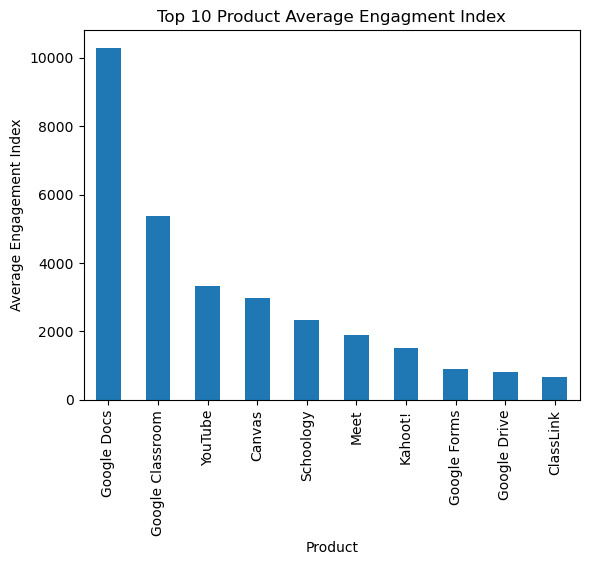

In [10]:
avg_product = df_product_engagement.groupby(["Product Name"])["engagement_index"].mean().sort_values(ascending=False).head(10)
print("Top 10 product based on average Engagement Index:\n",avg_product)
avg_product.plot(kind="bar")
plt.title("Top 10 Product Average Engagment Index")
plt.xlabel("Product")
plt.ylabel("Average Engagement Index")

- Google Docs has the highest Average Engagement index over time
- June(month 6) to July(Month 7)all product Engagement index declines which makes sense this is when the school year is coming to an end. 
- August(month 8) to September(month 9) all top 10 product average engagement index show an upward trend due to the new school year beggining. 
- Top 5 are:
    - Google Docs
    - Google Classroom
    - Youtube
    - Canvas
    - Schoology

Top 10 Product based on Average Engagement Index:
- Google Docs-         Average Engagement Index: 10290
- Google Classroom-     Average Engagement Index: 5366
- YouTube-              Average Engagement Index: 3331
- Canvas-               Average Engagement Index: 2969
- Schoology-            Average Engagement Index: 2337
- Meet-                 Average Engagement Index: 1903
- Kahoot!-              Average Engagement Index: 1503
- Google Forms-         Average Engagement Index:  889
- Google Drive-          Average Engagement Index: 814
- ClassLink-             Average Engagement Index: 667

Google Docs has the highest Average Engagement Index, this is the most engaged product.

Text(0, 0.5, 'Number of unique products')

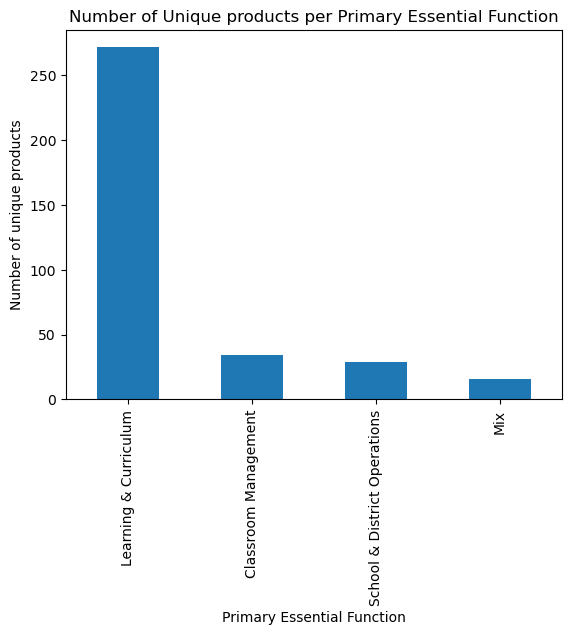

In [11]:
df_product_engagement["PEF"] = df_product_engagement["Primary Essential Function"].str.split("-").str[0]
df_product_engagement["PEF"] = df_product_engagement["PEF"].replace({"LC " : "Learning & Curriculum","CM ":"Classroom Management","SDO ":"School & District Operations","LC/CM/SDO ":"Mix"})
primary_essential_function = df_product_engagement.groupby("PEF")["Product Name"].nunique().sort_values(ascending = False)
primary_essential_function.plot(kind = "bar")
plt.title("Number of Unique products per Primary Essential Function")
plt.xlabel("Primary Essential Function")
plt.ylabel("Number of unique products")

- A majority of products primary essential function is learning and curriculum

Primary Essential Function average Engagement Index:
 PEF
School & District Operations    785.467373
Classroom Management            322.616484
Learning & Curriculum           223.237599
Mix                             203.554895
Name: engagement_index, dtype: float64


Text(0, 0.5, 'Average Engagement Index')

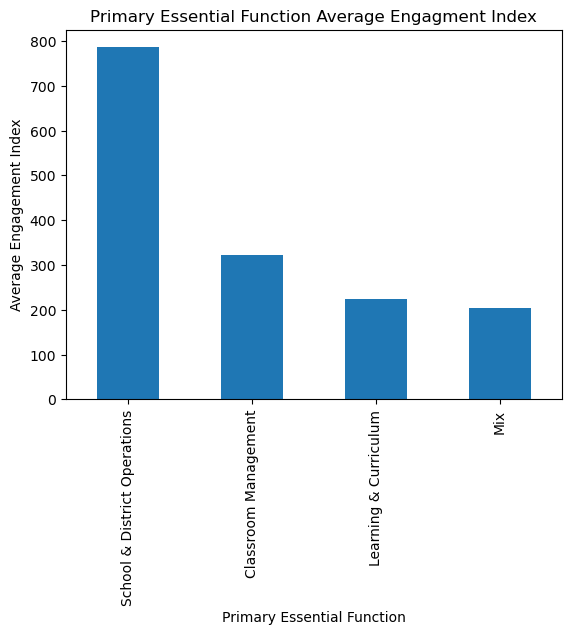

In [12]:
#primary essetial function vs average engagement index
avg_pef = df_product_engagement.groupby(["PEF"])["engagement_index"].mean().sort_values(ascending=False)
print("Primary Essential Function average Engagement Index:\n",avg_pef)
avg_pef.plot(kind="bar")
plt.title("Primary Essential Function Average Engagment Index")
plt.xlabel("Primary Essential Function")
plt.ylabel("Average Engagement Index")

- School and District Operations has the highest average engagement index, when looking into why School and District Operations would have higher Average Engagement Index, we see that Google Classroom, schoology and ClassLink are the top 3. These products are resource hubs so students would have higher page loads on these because they would get all their school information from there, such as course annoucements, assignments, course materials, and so on.

Text(0, 0.5, 'Average Engagement Index')

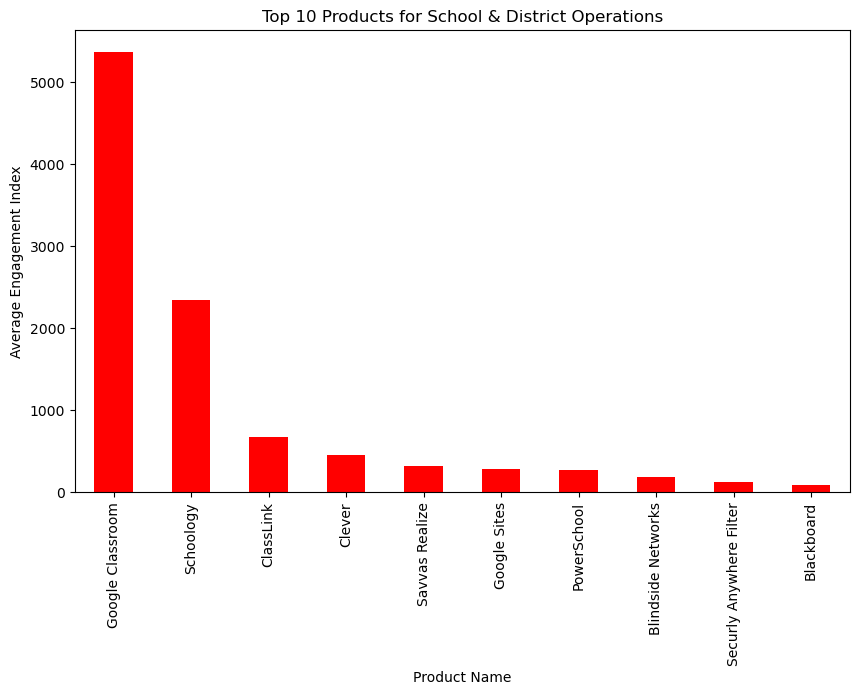

In [13]:
SDO_df = df_product_engagement.loc[df_product_engagement["PEF"] == "School & District Operations"]
CM_df = df_product_engagement.loc[df_product_engagement["PEF"] == "Classroom Management"]
LC_df = df_product_engagement.loc[df_product_engagement["PEF"] == "Learning & Curriculum"]
mix_df = df_product_engagement.loc[df_product_engagement["PEF"] == "Mix"]

def get_top_products(df):
    return df.groupby(["Product Name"])["engagement_index"].mean().sort_values(ascending = False).head(10)

SDO_df_top_products = get_top_products(SDO_df)
plt = SDO_df_top_products.plot.bar(figsize=(10,6), color = "red")
plt.set_title("Top 10 Products for School & District Operations")
plt.set_xlabel("Product Name")
plt.set_ylabel("Average Engagement Index")

Text(0, 0.5, 'Average Engagement Index')

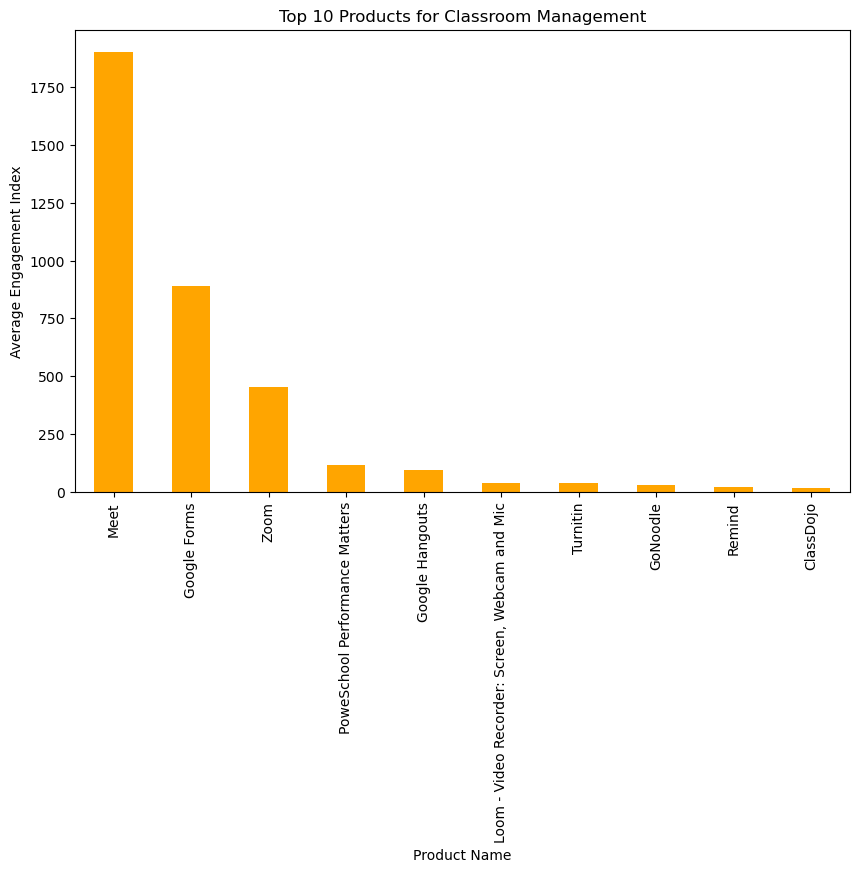

In [14]:
CM_df_top_products = get_top_products(CM_df)
plt = CM_df_top_products.plot.bar(figsize=(10,6), color = "orange")
plt.set_title("Top 10 Products for Classroom Management")
plt.set_xlabel("Product Name")
plt.set_ylabel("Average Engagement Index")

Text(0, 0.5, 'Average Engagement Index')

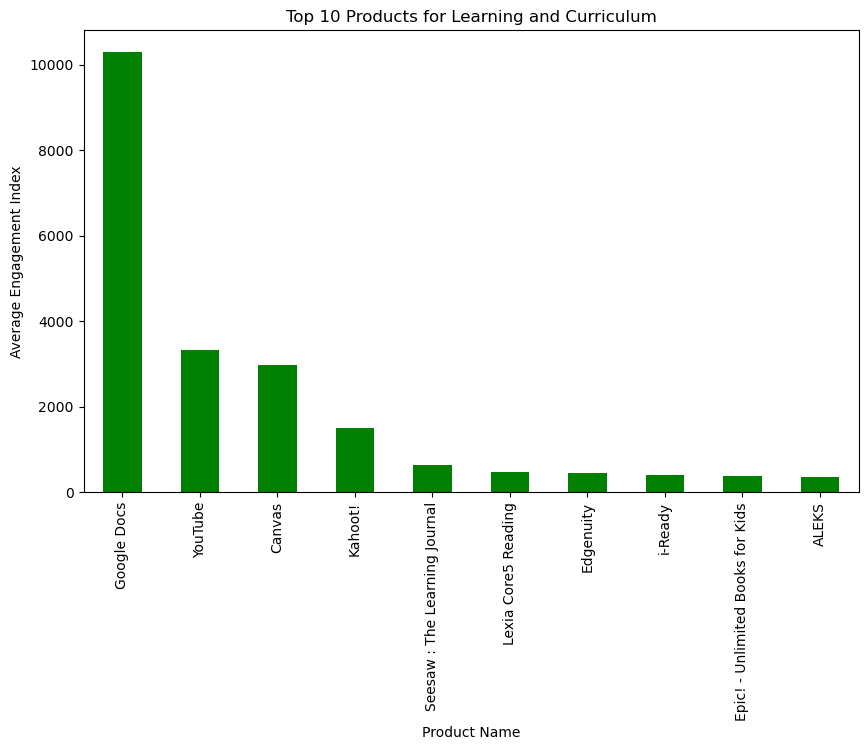

In [15]:
LC_df_top_products = get_top_products(LC_df)
plt = LC_df_top_products.plot.bar(figsize=(10,6), color = "green")
plt.set_title("Top 10 Products for Learning and Curriculum")
plt.set_xlabel("Product Name")
plt.set_ylabel("Average Engagement Index")

Text(0, 0.5, 'Average Engagement Index')

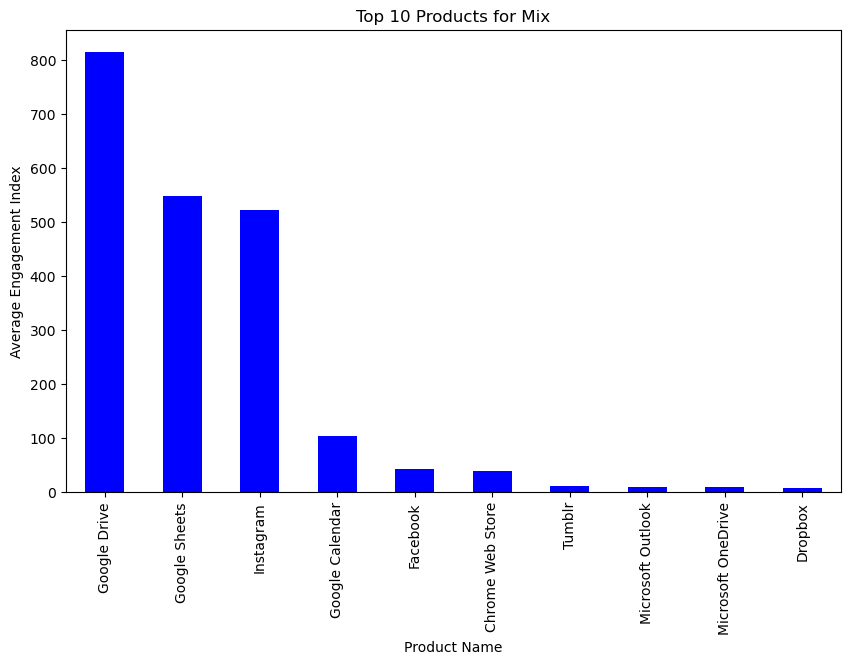

In [16]:
mix_df_top_products = get_top_products(mix_df)
plt = mix_df_top_products.plot.bar(figsize=(10,6), color = "blue")
plt.set_title("Top 10 Products for Mix")
plt.set_xlabel("Product Name")
plt.set_ylabel("Average Engagement Index")

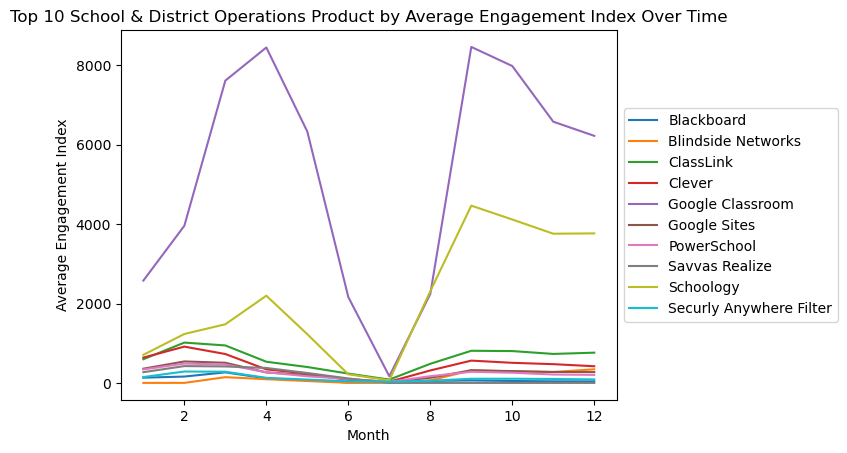

In [17]:
SDO_engagement_index_by_month_df = SDO_df.groupby(["Product Name", "month"])["engagement_index"].mean().sort_values(ascending=False)
SDO_engagement_index_by_month_df = SDO_engagement_index_by_month_df.reset_index()
top_10_SDO = SDO_engagement_index_by_month_df.groupby("Product Name")["engagement_index"].mean().sort_values(ascending=False).head(10)
top_10_SDO_df = SDO_engagement_index_by_month_df[SDO_engagement_index_by_month_df["Product Name"].isin(top_10_SDO.index)]
plt = top_10_SDO_df.pivot(index = "month", columns = "Product Name", values = "engagement_index").plot(kind = "line")
plt.set_title("Top 10 School & District Operations Product by Average Engagement Index Over Time")
plt.set_xlabel("Month")
plt.set_ylabel("Average Engagement Index")
plt.legend(loc = "center left", bbox_to_anchor=(1.0, 0.5))

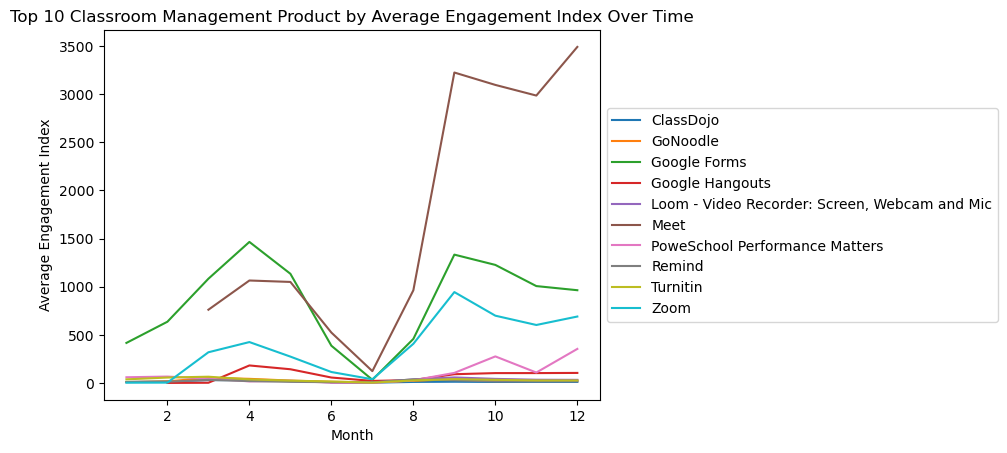

In [18]:
CM_engagement_index_by_month_df = CM_df.groupby(["Product Name", "month"])["engagement_index"].mean().sort_values(ascending=False)
CM_engagement_index_by_month_df = CM_engagement_index_by_month_df.reset_index()
top_10_CM = CM_engagement_index_by_month_df.groupby("Product Name")["engagement_index"].mean().sort_values(ascending=False).head(10)
top_10_CM_df = CM_engagement_index_by_month_df[CM_engagement_index_by_month_df["Product Name"].isin(top_10_CM.index)]
plt = top_10_CM_df.pivot(index = "month", columns = "Product Name", values = "engagement_index").plot(kind = "line")
plt.set_title("Top 10 Classroom Management Product by Average Engagement Index Over Time")
plt.set_xlabel("Month")
plt.set_ylabel("Average Engagement Index")
plt.legend(loc = "center left", bbox_to_anchor=(1.0, 0.5))

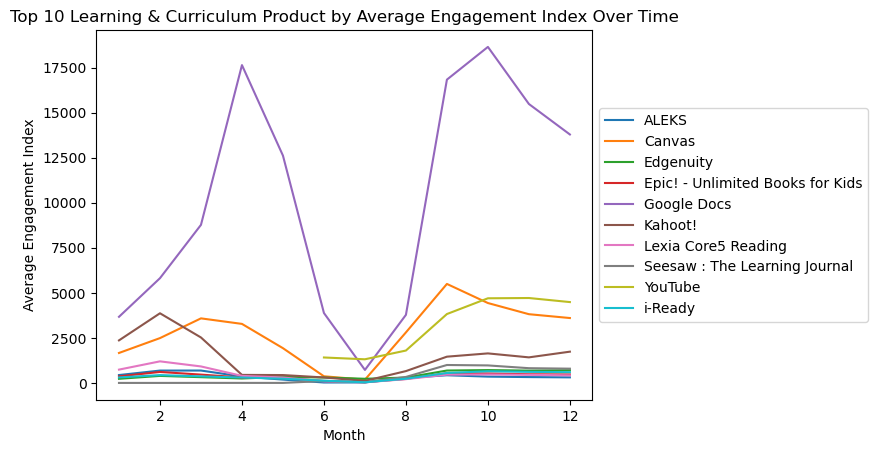

In [19]:
LC_engagement_index_by_month_df = LC_df.groupby(["Product Name", "month"])["engagement_index"].mean().sort_values(ascending=False)
LC_engagement_index_by_month_df = LC_engagement_index_by_month_df.reset_index()
top_10_LC = LC_engagement_index_by_month_df.groupby("Product Name")["engagement_index"].mean().sort_values(ascending=False).head(10)
top_10_LC_df = LC_engagement_index_by_month_df[LC_engagement_index_by_month_df["Product Name"].isin(top_10_LC.index)]
plt = top_10_LC_df.pivot(index = "month", columns = "Product Name", values = "engagement_index").plot(kind = "line")
plt.set_title("Top 10 Learning & Curriculum Product by Average Engagement Index Over Time")
plt.set_xlabel("Month")
plt.set_ylabel("Average Engagement Index")
plt.legend(loc = "center left", bbox_to_anchor=(1.0, 0.5))

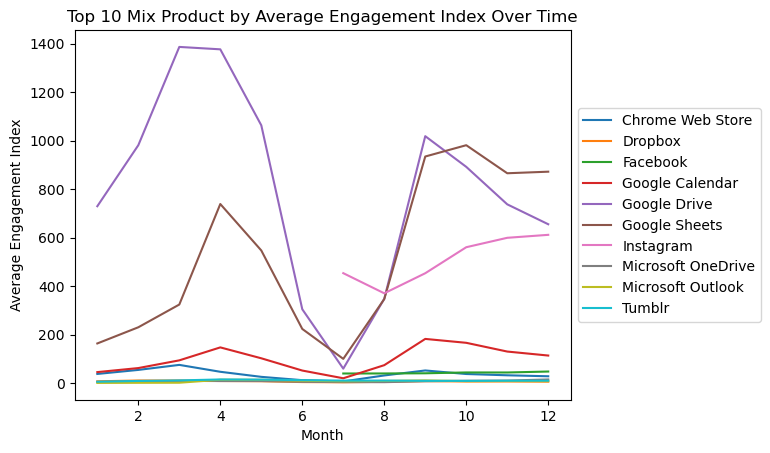

In [20]:
mix_engagement_index_by_month_df = mix_df.groupby(["Product Name", "month"])["engagement_index"].mean().sort_values(ascending=False)
mix_engagement_index_by_month_df = mix_engagement_index_by_month_df.reset_index()
top_10_mix = mix_engagement_index_by_month_df.groupby("Product Name")["engagement_index"].mean().sort_values(ascending=False).head(10)
top_10_mix_df = mix_engagement_index_by_month_df[mix_engagement_index_by_month_df["Product Name"].isin(top_10_mix.index)]
plt = top_10_mix_df.pivot(index = "month", columns = "Product Name", values = "engagement_index").plot(kind = "line")
plt.set_title("Top 10 Mix Product by Average Engagement Index Over Time")
plt.set_xlabel("Month")
plt.set_ylabel("Average Engagement Index")
plt.legend(loc = "center left", bbox_to_anchor=(1.0, 0.5))

Conclusion of analysis, digital learning engagement spikes during month 4 and month 9 and dips to lowest during month 7, top product for all 4 Primary essential function catergories are made from Google LLC. The top products are Google classroom, Google drive, Google Docs, and meet. Google LLC products are engaged with most over the course of 2020.